In [61]:
%run -i 'scraping.py'

In [223]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [62]:
assert len(dataframe_list) == 3

3


In [63]:
dji = dataframe_list[0]
sp_500 = dataframe_list[1]
nasdaq = dataframe_list[2]

In [65]:
assert len(dji) == len(sp_500)
assert len(dji) == len(nasdaq)
assert len(sp_500) == len(nasdaq)

In [245]:
dji = dji.sort_index()
sp_500 = sp_500.sort_index()
nasdaq = nasdaq.sort_index()

In [246]:
dji.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-06-15,17890.76,17890.76,17698.42,17791.17,17791.17,91920000.0
2015-06-16,17787.43,17919.62,17774.12,17904.48,17904.48,77510000.0
2015-06-17,17909.58,17998.00,17839.65,17935.74,17935.74,92410000.0
2015-06-18,17944.61,18174.73,17944.61,18115.84,18115.84,94460000.0
2015-06-19,18116.24,18117.71,18010.58,18015.95,18015.95,258300000.0


In [247]:
sp_500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-06-15,2091.34,2091.34,2072.49,2084.43,2084.43,3.061570e+09
2015-06-16,2084.26,2097.40,2082.10,2096.29,2096.29,2.919900e+09
2015-06-17,2097.40,2106.79,2088.86,2100.44,2100.44,3.222240e+09
2015-06-18,2101.58,2126.65,2101.58,2121.24,2121.24,3.520360e+09
2015-06-19,2121.06,2121.64,2109.45,2109.99,2109.99,4.449810e+09


In [248]:
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-06-15,5011.79,5035.37,4985.94,5029.97,5029.97,1.790280e+09
2015-06-16,5023.58,5063.06,5022.56,5055.55,5055.55,1.654820e+09
2015-06-17,5067.68,5080.11,5042.25,5064.88,5064.88,1.712820e+09
2015-06-18,5082.06,5143.32,5082.03,5132.95,5132.95,1.877920e+09
2015-06-19,5139.77,5140.17,5113.94,5117.00,5117.00,2.468310e+09


In [249]:
# constants
TRAIN_SPLIT = len(dji) - 10 # same for all data
START_INDEX = 20

In [250]:
#standard scaler
standard_scaler = StandardScaler()
dji_standarized = standard_scaler.fit_transform(dji.values)
sp500_standarized = standard_scaler.fit_transform(sp_500.values)
nasdaq_standarized = standard_scaler.fit_transform(nasdaq.values)

In [251]:
assert dji_standarized.shape == (len(dji), 6)
assert sp500_standarized.shape == (len(sp_500), 6)
assert nasdaq_standarized.shape == (len(nasdaq), 6)

In [252]:
def train_data(dataset, target_index, start_index, train_split):
    """
    """
    data = []
    labels = []
    target = dataset[:, target_index]

    # model will be given 20 bitcoin prices
    start_index = start_index
    end_index = train_split
    
    for i in range(start_index, end_index):
        indices = range(i - start_index, i)
        data.append(dataset[indices])
        labels.append(target[i])
    
    return np.array(data), np.array(labels)

In [253]:
dji_train, dji_label = train_data(dji_standarized, 4, START_INDEX, TRAIN_SPLIT)
sp500_train, sp500_label = train_data(sp500_standarized, 4, START_INDEX, TRAIN_SPLIT)
nasdaq_train, nasdaq_label = train_data(nasdaq_standarized, 4, START_INDEX, TRAIN_SPLIT)

In [254]:
# check shape of training data
assert dji_train.shape == (TRAIN_SPLIT - START_INDEX, 20, 6)
assert sp500_train.shape == (TRAIN_SPLIT - START_INDEX, 20, 6)
assert nasdaq_train.shape == (TRAIN_SPLIT - START_INDEX, 20, 6)

# check shape of label data
assert dji_label.shape == (TRAIN_SPLIT - START_INDEX,)
assert sp500_label.shape == (TRAIN_SPLIT - START_INDEX,)
assert nasdaq_label.shape == (TRAIN_SPLIT - START_INDEX,)

In [255]:
def validation_data(dataset, target_index, start_index):
    """
    """
    valid_data = []
    valid_labels = []
    target = dataset[:, target_index]

    # set index 
    start_index = start_index
    end_index = len(dataset)

    for i in range(start_index, end_index):
        indices = range(i - 20, i)
        valid_data.append(dataset[indices])
        valid_labels.append(target[i])

    return np.array(valid_data), np.array(valid_labels)

In [256]:
dji_valid_data, dji_valid_label = validation_data(dji_standarized, 4, TRAIN_SPLIT)
sp500_valid_data, sp500_valid_label = validation_data(sp500_standarized, 4, TRAIN_SPLIT)
nasdaq_valid_data, nasdaq_valid_label = validation_data(nasdaq_standarized, 4, TRAIN_SPLIT)

In [257]:
# check shape of validation data
assert dji_valid_data.shape == (10, 20, 6)
assert sp500_valid_data.shape == (10, 20, 6)
assert nasdaq_valid_data.shape == (10, 20, 6)

# check shape of validation label
assert dji_valid_label.shape == (10,)
assert sp500_valid_label.shape == (10,)
assert nasdaq_valid_label.shape == (10,)

In [300]:
# DIJ time series
dji_model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = dji_train.shape[-2:]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/dji_model.h5", save_best_only=True)
dji_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

history = dji_model.fit(dji_train, dji_label, epochs=100,
                    validation_data=(dji_valid_data, dji_valid_label),
                        callbacks=[callback, checkpoint_cb])

dji_predict = dji_model.predict(dji_valid_data)

Epoch 1/100
39/39 [==============================] - 2s 40ms/step - loss: 0.1763 - val_loss: 0.3830
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1333 - val_loss: 0.4225
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1291 - val_loss: 0.3186
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1156 - val_loss: 0.2850
Epoch 5/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1068 - val_loss: 0.2910
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1041 - val_loss: 0.3224
Epoch 7/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1023 - val_loss: 0.2104
Epoch 8/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0974 - val_loss: 0.3327
Epoch 9/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0963 - val_loss: 0.2850
Epoch 10/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0915 - val_loss: 0.2387

In [301]:
def unstandarize(predict, target_data):
    """
    """
    mean = target_data.mean()
    std = target_data.std()
    unstandarized_arr = predict*std + mean
    return unstandarized_arr

In [302]:
dji_unstan_predict = unstandarize(dji_predict, dji['Adj Close'].values)

In [303]:
def plot_valid_predict(data, train_split, predict, span):
    """
    """
    train_split = len(data) - train_split
    adj_close = [x for x in data['Adj Close'].values]
    train_date = data.index[:train_split]
            
    plt.figure(figsize=(18, 8))
    plt.plot(data.index[-20:-10], adj_close[-20:-10], label='History')
    plt.plot(data.index[-train_split:], adj_close[-train_split:], label='True Future')
    plt.plot(data.index[-train_split:], predict, label='Predicted Price')
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.show()

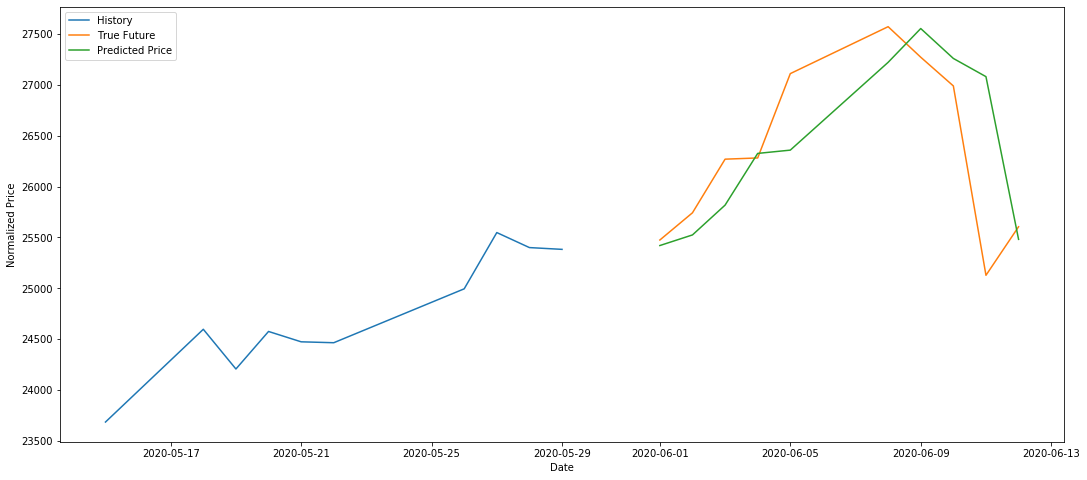

In [304]:
plot_valid_predict(dji, TRAIN_SPLIT, dji_unstan_predict, 20)

In [315]:
# S&P 500 model
sp500_model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = nasdaq_train.shape[-2:]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/sp500_model.h5", save_best_only=True)
sp500_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

history = sp500_model.fit(sp500_train, sp500_label, epochs=100,
                    validation_data=(sp500_valid_data, sp500_valid_label),
                        callbacks=[callback, checkpoint_cb])

sp500_predict = sp500_model.predict(sp500_valid_data)

Epoch 1/100
39/39 [==============================] - 2s 41ms/step - loss: 0.2144 - val_loss: 0.6047
Epoch 2/100
39/39 [==============================] - 1s 22ms/step - loss: 0.1432 - val_loss: 0.3848
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1194 - val_loss: 0.6529
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1178 - val_loss: 0.3869
Epoch 5/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1089 - val_loss: 0.4406
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1097 - val_loss: 0.3921
Epoch 7/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1053 - val_loss: 0.1882
Epoch 8/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1006 - val_loss: 0.4772
Epoch 9/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0992 - val_loss: 0.7837
Epoch 10/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0964 - val_loss: 0.3649

In [316]:
sp500_unstan_predict = unstandarize(sp500_predict, sp_500['Adj Close'].values)

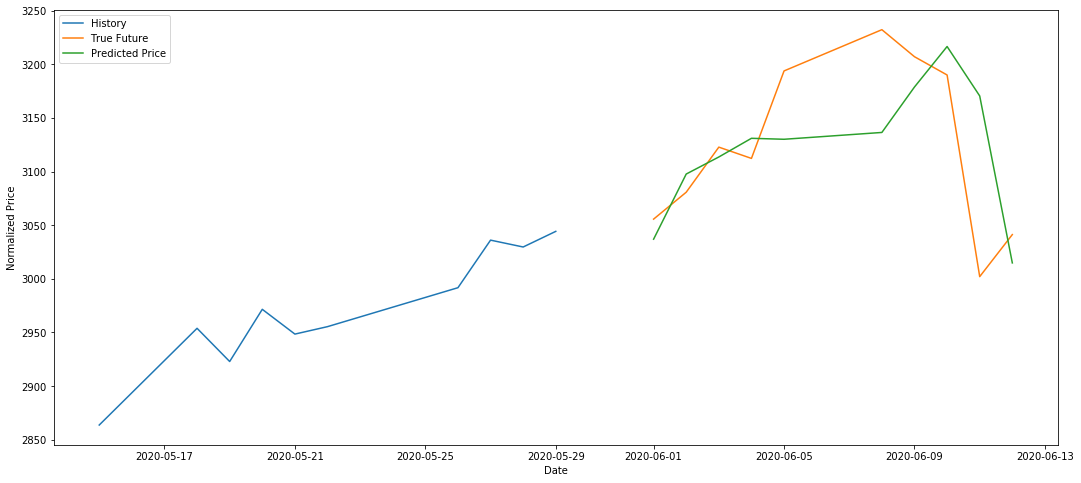

In [317]:
plot_valid_predict(sp_500, TRAIN_SPLIT, sp500_unstan_predict, 20)

In [311]:
# NASDAQ model
nasdaq_model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape = nasdaq_train.shape[-2:]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/nasdaq_model.h5", save_best_only=True)
nasdaq_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

history = nasdaq_model.fit(nasdaq_train, nasdaq_label, epochs=100,
                    validation_data=(nasdaq_valid_data, nasdaq_valid_label),
                        callbacks=[callback, checkpoint_cb])

nasdaq_predict = nasdaq_model.predict(nasdaq_valid_data)

Epoch 1/100
39/39 [==============================] - 2s 40ms/step - loss: 0.1960 - val_loss: 0.7259
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1276 - val_loss: 0.8592
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1122 - val_loss: 0.4938
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1077 - val_loss: 0.7922
Epoch 5/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1060 - val_loss: 0.4498
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.1014 - val_loss: 0.2778
Epoch 7/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0911 - val_loss: 0.3848
Epoch 8/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0919 - val_loss: 0.3678
Epoch 9/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0875 - val_loss: 0.1324
Epoch 10/100
39/39 [==============================] - 1s 21ms/step - loss: 0.0881 - val_loss: 0.4966

In [312]:
nasdaq_unstan_predict = unstandarize(nasdaq_predict, nasdaq['Adj Close'].values)

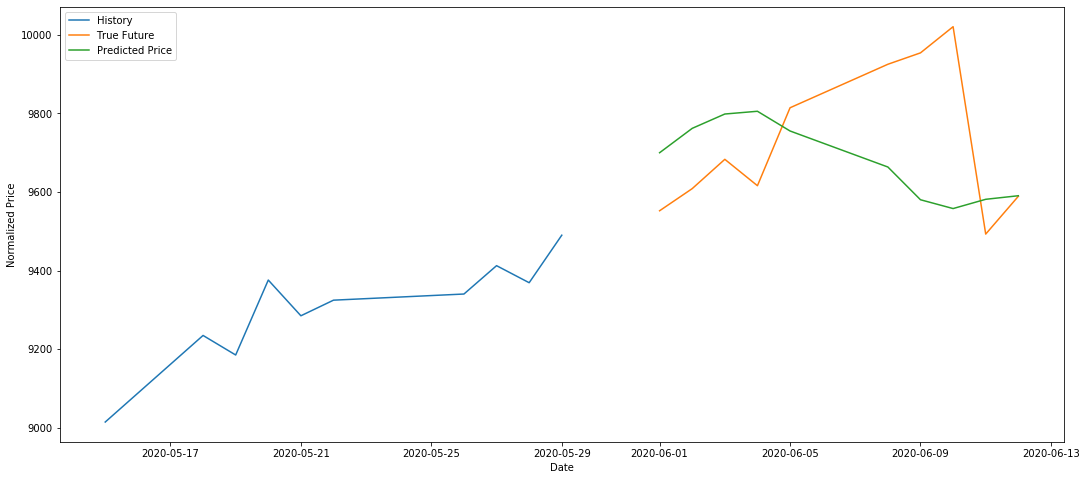

In [314]:
plot_valid_predict(nasdaq, TRAIN_SPLIT, nasdaq_unstan_predict, 20)